# Our Implementation

Only change made was to have `get_ref_solutions()` additionally return the solution matrix `u`. 

In [1]:
import numpy as np

"""
Helper function for computing reference solution to the given PDE at given points. 

INPUT: 
- pde_name: string; name of the PDE problem
- pde_coefs: dictionary containing coefficients of the PDE
- x: tuple of (x_res, x_left, x_upper, x_lower)
- t: tuple of (t_res, t_left, t_upper, t_lower)
- data_params: dictionary containing parameters used to generate the data
OUTPUT: 
- sol: 
"""
def get_ref_solutions(pde_name, pde_coefs, x, t, data_params): 
    if pde_name == "convection": 
        sol = np.vstack([np.sin(x[i].cpu().detach().numpy() - pde_coefs["beta"] * t[i].cpu().detach().numpy()) for i in range(len(x))])
    elif pde_name == "reaction_diffusion": 
        # unpack data-generation parameters
        x_range = data_params["x_range"]
        t_range = data_params["t_range"]
        x_num = data_params["x_num"]
        t_num = data_params["t_num"]
        res_idx = data_params["res_idx"]
        # generate grid
        x = np.linspace(x_range[0], x_range[1], x_num-1, endpoint=False).reshape(-1, 1) # exclude upper boundary
        t = np.linspace(t_range[0], t_range[1], t_num).reshape(-1, 1)
        x_mesh, t_mesh = np.meshgrid(x, t)
        # compute initial solution
        u0 = np.exp(-(1/2) * np.square((x - np.pi) / (np.pi / 4))).flatten()
        u = np.zeros((x_num, t_num))
        u[:-1,0] = u0

        IKX_pos = 1j * np.arange(0, (x_num-1) / 2 + 1, 1)
        IKX_neg = 1j * np.arange(-(x_num-1) / 2 + 1, 0, 1)
        IKX = np.concatenate((IKX_pos, IKX_neg))
        IKX2 = IKX * IKX
        # perform time-marching
        t_step_size = (t_range[1] - t_range[0]) / (t_num - 1)
        u_t = u0.copy()
        for i in range(t_num - 1): 
            # reaction component
            factor = u_t * np.exp(pde_coefs['rho'] * t_step_size)
            u_t = factor / (factor + (1 - u_t))
            # diffusion component
            factor = np.exp(pde_coefs['nu'] * IKX2 * t_step_size)
            u_hat = np.fft.fft(u_t) * factor
            u_t = np.real(np.fft.ifft(u_hat))
            u[:-1,i+1] = u_t

        # add back solution on the upper boundary using the periodic boundary condition
        u[-1,:] = u[0,:]
        # split the solution
        sol_left = u[:,0].reshape(-1,1)
        sol_upper = u[-1,:].reshape(-1,1)
        sol_lower = u[0,:].reshape(-1,1)
        sol_res = u[1:-1, 1:].T.reshape(-1,1)[res_idx]

        sol = np.vstack([sol_res, sol_left, sol_upper, sol_lower])

    else: 
        raise RuntimeError("{} is not a valid PDE name.".format(pde_name))
    
    return sol, u

"""
Helper function for generating data on a grid. 

INPUT: 
- x_range: list of size 2; lower and upper bounds of spatial variable x
- t_range: list of size 2; lower and upper bounds of temporal variable t
- x_num: positive integer; number of x points
- t_num: positive integer; number of t points
- random: boolean; indication whether to (uniformly) randomly from the grid
- num_res_samples: positive integer; number of random samples to draw for residual points
- device: string; the device that the samples will be stored at
OUTPUT: 
- x: tuple of (x_res, x_left, x_upper, x_lower)
- t: tuple of (t_res, t_left, t_upper, t_lower)
- data_params: dictionary containing parameters used to generate the data 
               including x_range, t_range, x_num, t_num, grid_multiplier, and res_idx
where: 
> res: numpy array / tensor of size (x_num-2)(t_num-1) * 2 or num_res_samples * 2; residual points (interior grid or random samples from it)
> b_left: numpy array / tensor of size (x_num) * 2; initial points (corresponding to initial time step)
> b_upper: numpy array / tensor of size (t_num) * 2; upper boundary points
> b_lower: numpy array / tensor of size (t_num) * 2; lower boundary points
> res_idx: numpy array of length (x_num-2)(t_num-1) or num_res_samples; corresponding indices of the sampled residual points from the interior grid
"""
def get_data(x_range, t_range, x_num, t_num, random=False, num_res_samples=1e4, device='cpu'):
  # generate initial and boundary points
  x = np.linspace(x_range[0], x_range[1], x_num).reshape(-1, 1)
  t = np.linspace(t_range[0], t_range[1], t_num).reshape(-1, 1)
  # initial time
  x_left = x.copy()
  t_left = t_range[0] * np.ones([x_num,1])
  # lower boundary
  x_lower = x_range[0] * np.ones([t_num,1])
  t_lower = t.copy()
  # upper boundary
  x_upper = x_range[1] * np.ones([t_num,1])
  t_upper = t.copy()
  # residual points
  x_mesh, t_mesh = np.meshgrid(x[1:-1], t[1:])
  data_params = {
    "x_range": x_range, 
    "t_range": t_range, 
    "x_num": x_num, 
    "t_num": t_num
  }
  if random: 
    mesh = np.hstack((x_mesh.flatten()[:, None], t_mesh.flatten()[:, None]))
    idx = np.random.choice(mesh.shape[0], num_res_samples, replace=False)
    x_res = mesh[idx, 0:1]
    t_res = mesh[idx, 1:2]
    data_params["res_idx"] = idx
  else: 
    x_res = x_mesh.reshape(-1,1)
    t_res = t_mesh.reshape(-1,1)
    data_params["res_idx"] = np.arange((x_num - 2) * (t_num - 1))

  # move data to target device
  if device != 'cpu': 
    x_left = torch.tensor(x_left, dtype=torch.float32, requires_grad=True).to(device)
    t_left = torch.tensor(t_left, dtype=torch.float32, requires_grad=True).to(device)
    x_upper = torch.tensor(x_upper, dtype=torch.float32, requires_grad=True).to(device)
    t_upper = torch.tensor(t_upper, dtype=torch.float32, requires_grad=True).to(device)
    x_lower = torch.tensor(x_lower, dtype=torch.float32, requires_grad=True).to(device)
    t_lower = torch.tensor(t_lower, dtype=torch.float32, requires_grad=True).to(device)
    x_res = torch.tensor(x_res, dtype=torch.float32, requires_grad=True).to(device)
    t_res = torch.tensor(t_res, dtype=torch.float32, requires_grad=True).to(device)

  # form tuples
  x = (x_res, x_left, x_upper, x_lower)
  t = (t_res, t_left, t_upper, t_lower)

  return x, t, data_params

"""
Helper function for initializing neural net parameters. 
"""
def init_weights(m):
  if isinstance(m, nn.Linear):
    # torch.nn.init.xavier_uniform_(m.weight)
    torch.nn.init.xavier_normal_(m.weight)
    m.bias.data.fill_(0.0)

"""
Helper function for computing l1 relative error. 

INPUT: 
- prediction: numpy array of predictions from the model
- target: numpy array of ground truths
OUTPUT: 
- error: scalar; computed relative error
"""
def l1_relative_error(prediction, target): 
    return np.sum(np.abs(target-prediction)) / np.sum(np.abs(target))

"""
Helper function for computing l2 relative error. 

INPUT: 
- prediction: numpy array of predictions from the model
- target: numpy array of ground truths
OUTPUT: 
- error: scalar; computed relative error
"""
def l2_relative_error(prediction, target): 
    return np.sqrt(np.sum((target-prediction)**2) / np.sum(target**2))

# From PINNs Failure Modes Paper

Removed flattening at the end of the `reaction_diffusion_discrete_solution()`. 

In [2]:
def function(u0: str):
    """Initial condition, string --> function."""

    if u0 == 'sin(x)':
        u0 = lambda x: np.sin(x)
    elif u0 == 'sin(pix)':
        u0 = lambda x: np.sin(np.pi*x)
    elif u0 == 'sin^2(x)':
        u0 = lambda x: np.sin(x)**2
    elif u0 == 'sin(x)cos(x)':
        u0 = lambda x: np.sin(x)*np.cos(x)
    elif u0 == '0.1sin(x)':
        u0 = lambda x: 0.1*np.sin(x)
    elif u0 == '0.5sin(x)':
        u0 = lambda x: 0.5*np.sin(x)
    elif u0 == '10sin(x)':
        u0 = lambda x: 10*np.sin(x)
    elif u0 == '50sin(x)':
        u0 = lambda x: 50*np.sin(x)
    elif u0 == '1+sin(x)':
        u0 = lambda x: 1 + np.sin(x)
    elif u0 == '2+sin(x)':
        u0 = lambda x: 2 + np.sin(x)
    elif u0 == '6+sin(x)':
        u0 = lambda x: 6 + np.sin(x)
    elif u0 == '10+sin(x)':
        u0 = lambda x: 10 + np.sin(x)
    elif u0 == 'sin(2x)':
        u0 = lambda x: np.sin(2*x)
    elif u0 == 'tanh(x)':
        u0 = lambda x: np.tanh(x)
    elif u0 == '2x':
        u0 = lambda x: 2*x
    elif u0 == 'x^2':
        u0 = lambda x: x**2
    elif u0 == 'gauss':
        x0 = np.pi
        sigma = np.pi/4
        u0 = lambda x: np.exp(-np.power((x - x0)/sigma, 2.)/2.)
    return u0

def reaction(u, rho, dt):
    """ du/dt = rho*u*(1-u)
    """
    factor_1 = u * np.exp(rho * dt)
    factor_2 = (1 - u)
    u = factor_1 / (factor_2 + factor_1)
    return u

def diffusion(u, nu, dt, IKX2):
    """ du/dt = nu*d2u/dx2
    """
    factor = np.exp(nu * IKX2 * dt)
    u_hat = np.fft.fft(u)
    u_hat *= factor
    u = np.real(np.fft.ifft(u_hat))
    return u

def reaction_diffusion_discrete_solution(u0 : str, nu, rho, nx = 256, nt = 100):
    """ Computes the discrete solution of the reaction-diffusion PDE using
        pseudo-spectral operator splitting.
    Args:
        u0: initial condition
        nu: diffusion coefficient
        rho: reaction coefficient
        nx: size of x-tgrid
        nt: number of points in the t grid
    Returns:
        u: solution
    """
    L = 2*np.pi
    T = 1
    dx = L/nx
    dt = T/nt
    x = np.arange(0, L, dx) # not inclusive of the last point
    t = np.linspace(0, T, nt).reshape(-1, 1)
    X, T = np.meshgrid(x, t)
    u = np.zeros((nx, nt))

    IKX_pos = 1j * np.arange(0, nx/2+1, 1)
    IKX_neg = 1j * np.arange(-nx/2+1, 0, 1)
    IKX = np.concatenate((IKX_pos, IKX_neg))
    IKX2 = IKX * IKX

    # call u0 this way so array is (n, ), so each row of u should also be (n, )
    u0 = function(u0)
    u0 = u0(x)

    u[:,0] = u0
    u_ = u0
    for i in range(nt-1):
        u_ = reaction(u_, rho, dt)
        u_ = diffusion(u_, nu, dt, IKX2)
        u[:,i+1] = u_

    # u = u.T
    # u = u.flatten()
    return u

# Comparing Results

We expect the solution obtained from our implementation to have dimension $257 \times 101$. 
Since the Mahoney paper ignores the upper boundary of $x$, the solution is supposed to have dimension $256 \times 101$. 

Note that `nx` refers to the number of spatial points excluding the right end-point but `nt` is inclusive on both ends of $t$. 

In [3]:
# compute reference solutions
x, t, data_params = get_data([0, 2 * np.pi], [0,1], 257, 101, random=False)
_, u = get_ref_solutions("reaction_diffusion", {"nu": 3, "rho":5}, x, t, data_params)
u_ref = reaction_diffusion_discrete_solution('gauss', nu=3, rho=5, nx=256, nt=101)

In [4]:
# solution dimensions
print(u.shape)
print(u_ref.shape)

(257, 101)
(256, 101)


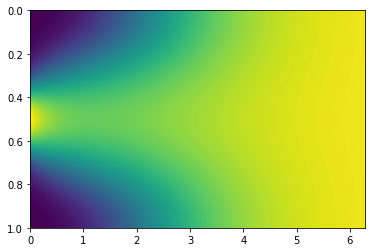

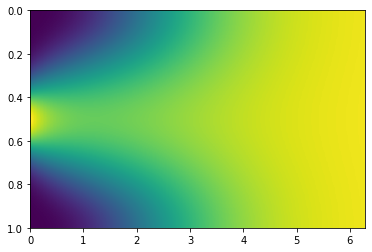

In [5]:
# visualize solutions
import matplotlib.pyplot as plt
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.show()
plt.imshow(u_ref, extent=[0,np.pi*2,1,0], aspect='auto')

In [6]:
# compare results numerically
print(l1_relative_error(u[:-1,:], u_ref))
print(l2_relative_error(u[:-1,:], u_ref))

0.0035861497563633897
0.004020668372375464
